## 👨🏻‍💻Практика - Заполнение пропущенных значений
Замена пропущенных значений в столбце "Возраст" средним значением возраста. 

Адаптируйте этот код под свои данные: укажите правильные имена столбцов, типы признаков (числовые, категориальные) и выберите подходящую модель (линейная или логистическая).
 Проанализируйте результаты: сравните MSE или accuracy с результатами модели без предобработки данных, чтобы оценить его влияние.

✔️**Решение:**
Использован датасет Titanic 
### ✔ Импорт библиотек: 
Импортируем все необходимые библиотеки

In [13]:
import pandas as pd

# для разделения данных
from sklearn.model_selection import train_test_split
# для создания модели
from sklearn.linear_model import LogisticRegression
# для оценки качества
from sklearn.metrics import accuracy_score 
# Восстановление (импутация) данных с помощью Python
from sklearn.impute import SimpleImputer
# преобразования к определённым столбцам внутри набора данных
from sklearn.compose import ColumnTransformer
# для создания конвейера шагов предварительной обработки данных и моделирования.
from sklearn.pipeline import Pipeline
# для стандартизации набора данных(вычитание ср.знач.и деления на станд.откл)
from sklearn.preprocessing import StandardScaler
# программирование категориальных переменных как двоичных векторов.
from sklearn.preprocessing import OneHotEncoder

# графики
import matplotlib.pyplot as plt
import seaborn as sns

### ✔ Загрузка и подготовка данных: 
Загружаем данные - запишем в датафрейм датасет Titanic из библиотеки сиборна.

In [33]:
data = sns.load_dataset("titanic")
data.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [34]:
# Убираем строки с пустыми значениями в целевой переменной (Survived)
data = data.dropna(subset=['survived'])

### ✔ Определение признаков и целевой переменной: 
Указываем, какие столбцы в данных являются признаками (X) и какой столбец - целевой переменной (y).  
Предположим, что 'survived' - выживший (0 - не выжил, 1 - выжил), а остальные столбцы - признаки

In [35]:
X = data.drop(columns=['survived'])  
y = data['survived']  

### ✔ Определяем числовые и категориальные признаки(если есть).
Запишем в переменные списки с названиями столбцов с числовыми и категориальными данными из датасета.

In [36]:
# Определение числовых признаков
numeric_features = ['age', 'fare', 'sibsp', 'parch']

#  Определение категориальных признаков
categorical_features = ['sex', 'class', 'embark_town']

### ✔ Разделение данных: 
Разделяем данные на обучающую и тестовую выборки в соотношении 80/20. 

random_state используется для воспроизводимости результатов.


In [37]:
X_train, X_test, y_train, y_test = (
    train_test_split(X, y, 
                     test_size=0.2, 
                     random_state=1))

### ✔ Логистическая регрессия без предобработки:
#### Удаляем пропуски

In [38]:
# Удалим строки с пропущенными знач.
X_train_no_prep = X_train.dropna()
y_train_no_prep = y_train.loc[X_train_no_prep.index]

X_test_no_prep = X_test.dropna()
y_test_no_prep = y_test.loc[X_test_no_prep.index]

#### Создание и обучение модели: 

In [39]:
model_logreg_no_prep = LogisticRegression(max_iter=200)
model_logreg_no_prep.fit(
    X_train_no_prep.select_dtypes(include=['number']), 
    y_train_no_prep)

LogisticRegression(max_iter=200)

#### Оценка модели  без предобработки:
Сравнивая предсказанные значения (ypred) с фактическими (ytest).

In [40]:
# Оценка модели
y_pred_no_prep = (
    model_logreg_no_prep.predict(
        X_test_no_prep.select_dtypes(include=['number']))
                 )

accuracy_no_prep = accuracy_score(y_test_no_prep, 
                                  y_pred_no_prep)

print(f"Accuracy (Логистическая регрессия без \
предобработки): {accuracy_no_prep:.4f}")

Accuracy (Логистическая регрессия без предобработки): 0.7027


 ### ✔ Логистическая регрессия c предобработкой ###
#### Пайплайн предобработки данных 
 
 - Числовые признаки (заполнение пропусков средним, стандартизация)
 - Категориальные признаки (заполнение пропусков, one-hot encoding)
 - Используем ColumnTransformer для объединения преобразователей в один.
 - Пайплайн для логистической регрессии с предобработкой
 - Обучение и оценка модели
 
 - Создаем конвейеры Pipeline для обработки каждого типа признаков.


In [41]:
# Числовые признаки (заполнение пропусков средним, стандартизация)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Категориальные признаки (заполнение пропусков, one-hot encoding)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Объединение всех преобразований
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Пайплайн для логистической регрессии с предобработкой
model_pipeline_logreg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=200))
])

# Обучение и оценка модели
model_pipeline_logreg.fit(X_train, y_train)
y_pred_logreg = model_pipeline_logreg.predict(X_test)
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
print(f"Accuracy (Логистическая регрессия с \
предобработкой): {accuracy_logreg:.4f}")

Accuracy (Логистическая регрессия с предобработкой): 0.7933


### ✔ Создание конвейера модели :
Создаем конвейеры, которые сначала применяют предобработку данных, а затем обучают модель (линейную или логистическую регрессию).


In [32]:
#Создание конвейера модели
model_pipeline_logreg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression())
])

model_logreg = model_pipeline_logreg.fit(X_train, y_train)
y_pred_logreg = model_logreg.predict(X_test)
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
print(f"Accuracy (Логистическая регрессия): {accuracy_logreg}")

Accuracy (Логистическая регрессия): 0.7988826815642458


### ✔ Сравним модель с предобработкой и без предобработки:

In [46]:
if accuracy_no_prep > accuracy_logreg:
    print(f"Модель без предобработки лучше: \
Accuracy {accuracy_no_prep:.4f} > {accuracy_logreg:.4f}")
elif accuracy_no_prep < accuracy_logreg:
    print(f"Модель с предобработкой лучше: \
Accuracy {accuracy_logreg:.4f} > {accuracy_no_prep:.4f}")
else:
    print(f"Обе модели имеют одинаковую точность\
Accuracy: {accuracy_no_prep:.4f}")

Модель с предобработкой лучше: 0.7933 > 0.7027


Посмотрим на графики до предобработки данных и после

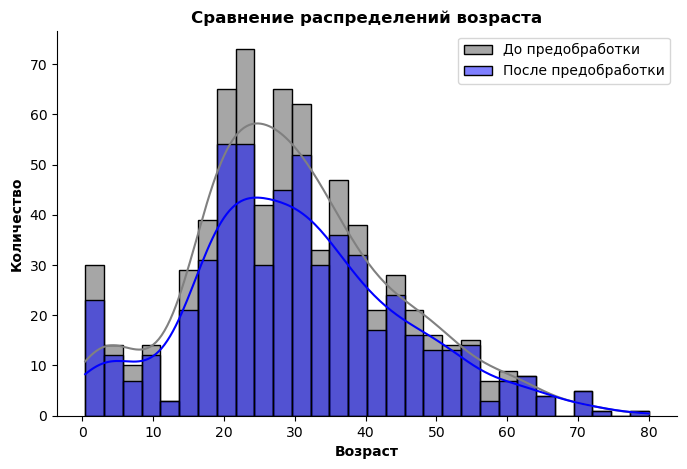

In [59]:
# Объединяем оба распределения на одном графике
plt.figure(figsize=(8, 5))

# Гистограмма до предобработки
sns.histplot(data['age'], 
             bins=30, 
             kde=True,
             color='grey',
             alpha=0.7, 
             edgecolor='black',
             label='До предобработки')

# Гистограмма после предобработки
sns.histplot(X_train['age'], 
             bins=30, 
             kde=True, 
             color='blue',
             label='После предобработки')

# Настройка графика
plt.xlabel('Возраст', fontweight="bold")
plt.ylabel('Количество', fontweight="bold")
plt.title('Сравнение распределений возраста',
          fontsize=12, fontweight="bold")
plt.legend()
# сетка
plt.grid(False) 
#уберем границы в графике-despine удаляет правую и верхнюю границы 
sns.despine()
# Отображаем график
plt.show()